# Meet Our Group

  * Linda Sekhoasha (222004139)
  * Wandile Ngobese (222056013)
  * Khonzinkosi Mkhize (219005273)
  * Samukelo Mkhize (220009930)


# Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import re
import string
import pickle

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# keras (as per requirement)
# quick start: https://colab.research.google.com/github/mattdangerw/keras-io/blob/new-landing-and-theme/quickstarts/keras_quickstart.ipynb
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import keras.backend as K
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, GRU, Flatten, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data pre-processing

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#df = pd.read_csv(r"/content/drive/MyDrive/dataset/sentiment_dataset.csv")
file_path = "/content/drive/MyDrive/dataset/sentiment_dataset.csv"

# column names (since the file has no headers)
columns = ['label', 'ids', 'date', 'flag', 'user', 'text']

df = pd.read_csv(file_path, encoding='latin-1', names=columns)

# drop the unnececary columns
df = df[['text', 'label']]

print(f"Shape: {df.shape}")
df.head()

Shape: (1600000, 2)


,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [15]:
# define the english stopwords
stop_words = set(stopwords.words('english'))

In [16]:
# function for cleaning up text (e.g. removing the @ tags from the tweets)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [17]:
df['cleaned_text'] = df['text'].apply(clean_text)

# convert targets: 0 -> 0 (negative), 4 -> 1 (positive)
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)

df[['cleaned_text', 'label']].head()

,cleaned_text,label
0,thats bummer shoulda got david carr third day,0
1,upset cant update facebook texting might cry r...,0
2,dived many times ball managed save rest go bounds,0
3,whole body feels itchy like fire,0
4,behaving im mad cant see,0


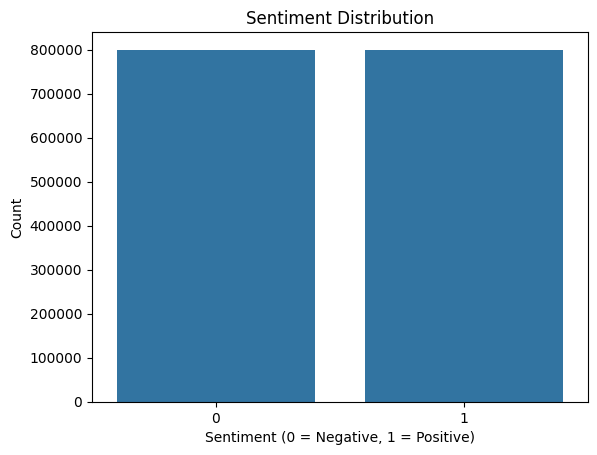

In [18]:
sns.countplot(x='label', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

In [19]:
X = df['cleaned_text']
y = pd.get_dummies(df['label']).values
num_classes = df['label'].nunique()

print(X.head())
print(y[:5])
print(f"Number of Classes: {num_classes}")

0        thats bummer shoulda got david carr third day
1    upset cant update facebook texting might cry r...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                             behaving im mad cant see
Name: cleaned_text, dtype: object
[[ True False]
 [ True False]
 [ True False]
 [ True False]
 [ True False]]
Number of Classes: 2


# LSTM

In [20]:
# https://www.kaggle.com/code/muradulislam002/sentiment-analysis-on-twitter-using-cnn-lstm
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [21]:
# train test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1280000,) (320000,) (1280000, 2) (320000, 2)


In [22]:
# tokenization
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

In [23]:
# tokenization and Padding
max_features = 20000
max_words = 100
embed_dim = 100

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)  # tokenize based on X_train

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_words)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_words)

In [24]:
batch_size = 128
epochs = 5

In [25]:
# define the model
def get_model(max_features, embed_dim):
    K.clear_session()
    lstm_model = Sequential()
    lstm_model.add(Embedding(max_features, embed_dim, input_length=max_words))
    lstm_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    lstm_model.add(MaxPooling1D(pool_size=2))
    lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    lstm_model.add(Dense(2, activation='softmax'))
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

In [26]:
# train the model
def model_train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

In [30]:
def model_evaluate():
    # predict class with test set
    y_pred_test = np.argmax(lstm_model.predict(X_test_pad), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))

    # classification report
    print('\n')
    print(classification_report(np.argmax(y_test, axis=1), y_pred_test))

    # confusion matrix
    confmat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

In [28]:
# train the model
max_features = 20000
embed_dim = 100
lstm_model = get_model(max_features, embed_dim)
model_train(lstm_model, X_train_pad, y_train, X_test_pad, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1777s 177ms/step - accuracy: 0.7668 - loss: 0.4792 - val_accuracy: 0.7936 - val_loss: 0.4380
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1802s 180ms/step - accuracy: 0.8063 - loss: 0.4179 - val_accuracy: 0.7973 - val_loss: 0.4339
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1723s 172ms/step - accuracy: 0.8208 - loss: 0.3921 - val_accuracy: 0.7963 - val_loss: 0.4366
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1773s 177ms/step - accuracy: 0.8349 - loss: 0.3668 - val_accuracy: 0.7948 - val_loss: 0.4503
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1752s 175ms/step - accuracy: 0.8473 - loss: 0.3425 - val_accuracy: 0.7908 - val_loss: 0.4669


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 198s 20ms/step
Accuracy:	79.1%


              precision    recall  f1-score   support

           0       0.80      0.78      0.79    160000
           1       0.78      0.81      0.79    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



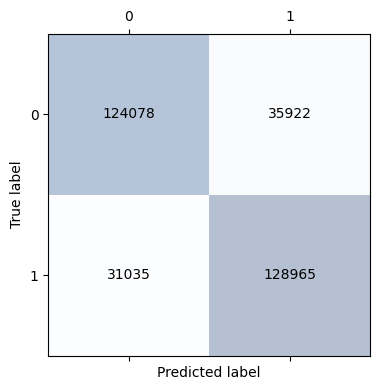

In [31]:
# evaluate model with test set
model_evaluate()

# GRU Model

In [32]:
# tokenize and pad
max_words = 20000
max_len = 40
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [36]:
# model definition
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embed_dim),
    GRU(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 40, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,031,937 (7.75 MB)

 Trainable params: 2,031,937 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1021s 102ms/step - accuracy: 0.6947 - loss: 0.5244 - val_accuracy: 0.8262 - val_loss: 0.3854
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1043s 102ms/step - accuracy: 0.8351 - loss: 0.3698 - val_accuracy: 0.8302 - val_loss: 0.3775
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1008s 101ms/step - accuracy: 0.8483 - loss: 0.3443 - val_accuracy: 0.8308 - val_loss: 0.3774
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1038s 100ms/step - accuracy: 0.8617 - loss: 0.3191 - val_accuracy: 0.8298 - val_loss: 0.3815
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1040s 100ms/step - accuracy: 0.8736 - loss: 0.2949 - val_accuracy: 0.8264 - val_loss: 0.3965


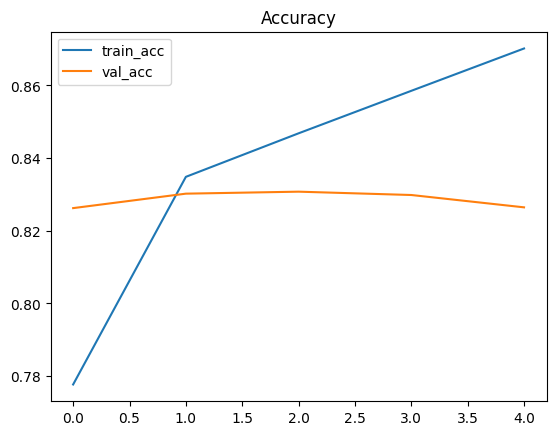

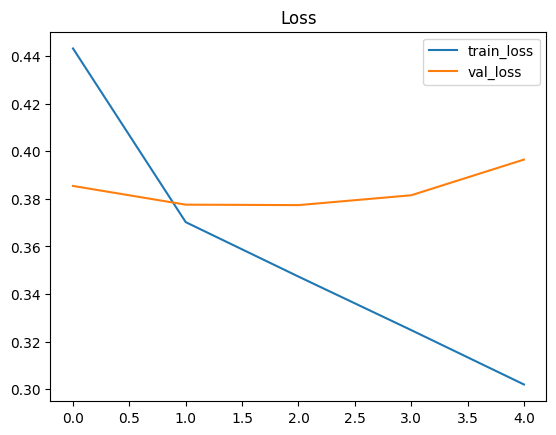

In [38]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()